In [1]:
%run load-clean-select.ipynb

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Morphology was measured for 610.0 cells.

The numbers of cells and nuclei correspond to each other.

The are no duplicated column names: True
The are no duplicated column names: True
Cytoplasm measurements were taken for 610 cells.

The are no duplicated column names: True
Read biomarkers normalised by to min gain
Biomarkers were measured for 610 cells.

The are no duplicated column names: True

Full dataset has shape: (610, 484)
Initial shape is: (610, 484)
Features with zero variance:
 Index(['centerZ_cell', 'eulernumber_cell', 'children_cytoplasm_count_cell',
       'loc_centermassintensityZ_wga', 'loc_centerZ_cell',
       'loc_maxintensityZ_wga', 'centerZ_nucl', 'eulernumber_nucl',
       'children_cells_count', 'children_cytoplasm_count_nucl',
       'loc_centermassintensityZ_dapi', 'loc_centerZ_nucl',
       'loc_maxintensityZ_dapi', 'centerZ_cyto',
       'loc_centermassintensityZ_ker', 'loc_centermassintensityZ_vim',
       'loc_centerZ', 'loc_maxintensityZ_ker', 'loc_maxinten

# Which dataset?

In [2]:
# The full dataset
# df = measurements
# Dataset without clusters at 64kPa
# df = measurements_red
# Dataset without 0.5kPa, 8kPa and clusters at 64kPa
df = measurements_5
# Dataset without 0.5kPa, 8kPa and clusters at 64kPa with balanced classes
# df = measurements_b

# Some functions

In [3]:
def plot_corr(correlations, mask=False, threshold=0.9, annot=False):
    if mask:
        mask = np.zeros_like(correlations)
        mask[abs(correlations) < threshold] = 1

    plt.rcParams['figure.figsize'] = (10, 10)

    sns.heatmap(correlations, 
                mask=mask, annot=annot,
                vmin=-1, vmax=1,
                cmap=sns.color_palette("RdBu_r", 100));

# Correlation between geometric features and biomarker expression

In [ ]:
df['stiffness_num'] = pd.to_numeric(df.stiffness)

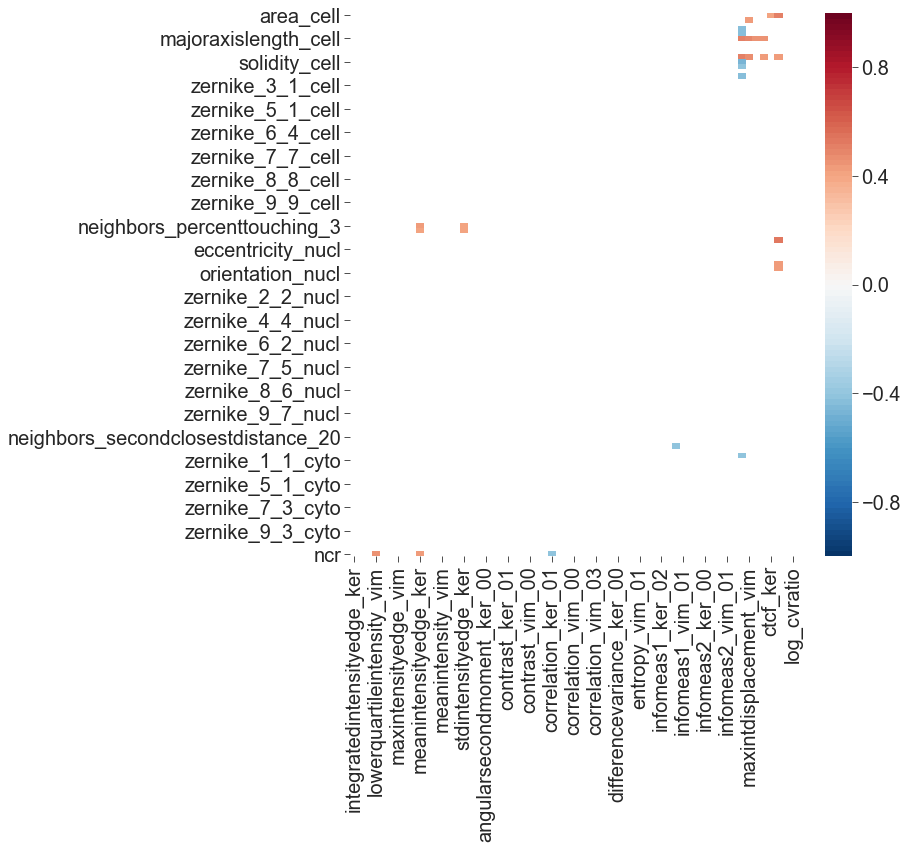

In [9]:
plot_corr(df.corr().loc[geom_cols, biom_cols], mask=True, threshold=0.4)

## Cytokeratin expression vs morphology

### Pearson's correlation

In [13]:
df[geom_cols].corrwith(df.ctcf_ker).abs().sort_values(ascending=False).head(5)

area_cell               0.418001
perimeter_cell          0.389690
majoraxislength_cell    0.374097
maximumradius_cyto      0.336413
majoraxislength_nucl    0.297631
dtype: float64

### Spearman's correlation

In [22]:
df[geom_cols].corrwith(df.ctcf_ker, method='spearman').abs().sort_values(ascending=False).head(5)

area_cell               0.396147
maximumradius_cyto      0.330417
ncr                     0.310991
perimeter_cell          0.310069
majoraxislength_cell    0.292058
dtype: float64

In [ ]:
sns.lmplot(x='area_cell', y='ctcf_ker', data=df, fit_reg=True, legend=False);

In [ ]:
sns.lmplot(x='area_cell', y='ctcf_ker', col='stiffness', data=df, fit_reg=True, legend=False);

In [ ]:
sns.lmplot(x='maximumradius_cyto', y='ctcf_ker', data=df, fit_reg=True, legend=False);

In [ ]:
sns.lmplot(x='maximumradius_cyto', y='ctcf_ker', col='stiffness', data=df, fit_reg=True, legend=False);

In [ ]:
sns.lmplot(x='ncr', y='ctcf_ker', data=df, fit_reg=True, order=1, legend=False);

### At each stiffness value

In [ ]:
for s in df.stiffness.unique():
    corr = df.loc[df.stiffness == s, geom_cols].corrwith(df.loc[df.stiffness == s, 'ctcf_ker']).abs().sort_values(ascending=False)
    print("Stiffness value: {}\n {} \n".format(s, corr[corr>0.5]))


## Vimentin expression vs morphology

### Pearson's correlation

In [ ]:
df[geom_cols].corrwith(df.ctcf_vim).abs().sort_values(ascending=False).head(5)

### Spearman's correlation

In [ ]:
df[geom_cols].corrwith(df.ctcf_vim, method='spearman').abs().sort_values(ascending=False).head(5)

In [ ]:
sns.lmplot(x='area_cell', y='ctcf_vim', data=df, fit_reg=True, order=1, legend=False);

In [ ]:
sns.lmplot(x='area_cell', y='ctcf_vim', col='stiffness', data=df, fit_reg=True, legend=False);

In [ ]:
sns.lmplot(x='area_nucl', y='ctcf_vim', data=df, fit_reg=True, order=1, legend=False);

In [ ]:
sns.lmplot(x='area_nucl', y='ctcf_vim', col='stiffness', data=df, fit_reg=True, legend=False);

In [ ]:
sns.lmplot(x='majoraxislength_nucl', y='ctcf_vim', data=df, fit_reg=True, order=1, legend=False);

### At each stiffness value

In [ ]:
no_zf = [col for col in geom_cols if 'zernike' not in col]
for s in df.stiffness.unique():
    corr = df.loc[df.stiffness == s, no_zf].corrwith(df.loc[df.stiffness == s, 'ctcf_vim']).abs().sort_values(ascending=False)
    print("Stiffness value: {}\n {} \n".format(s, corr[corr>0.6]))


## CV ratio vs morphology

### Pearson's correlation

In [ ]:
df[geom_cols].corrwith(df.cvratio).abs().sort_values(ascending=False).head(5)

### Spearman's correlation

In [ ]:
df[geom_cols].corrwith(df.cvratio, method='spearman').abs().sort_values(ascending=False).head(5)

In [ ]:
sns.lmplot(x='neighbors_percenttouching_30', y='cvratio', data=df, fit_reg=True, order=1, legend=False);

# Predict expression of biomarkers using geometric features

## Cytokeratin

In [ ]:
# Feature map and response variable
cols = geom_cols

X = pd.concat([df[cols], df.stiffness_num], axis=1)
y = df.ctcf_ker

# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

rf_reg = RandomForestRegressor()

In [ ]:
best_rf_reg = rf.random_search_param(rf_reg, X_train, y_train)

** Save the best estimator **

In [ ]:
joblib.dump(best_rf_reg, 'models/geomstiff-to-ker-reg.pkl')

In [ ]:
rf.train_test(rf_reg, 1, X_train, X_test, y_train, y_test)

In [ ]:
important_features = rf.get_important_features(rf_reg, X.columns)

## Vimentin

In [ ]:
# Feature map and response variable
cols = geom_cols 

X = pd.concat([df[cols], df.stiffness_num], axis=1)
y = df.ctcf_vim

# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

rf_reg = RandomForestRegressor()

In [ ]:
best_rf_reg = rf.random_search_param(rf_reg, X_train, y_train)

** Save the best estimator **

In [ ]:
joblib.dump(best_rf_reg, 'models/geomstiff-to-vim-reg.pkl')

In [ ]:
rf.train_test(best_rf_reg, 1, X_train, X_test, y_train, y_test)

In [ ]:
important_features = rf.get_important_features(best_rf_reg, X.columns)

# Create 4 groups based on biomarker expression and predict it using morphology 

## Create 4 groups

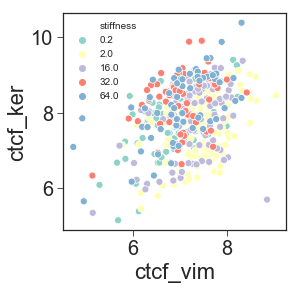

In [23]:
plt.rcParams['figure.figsize'] = (4, 4)
sns.scatterplot(x=np.log(df.ctcf_vim), y=np.log(df.ctcf_ker), 
                hue=df.stiffness, s=50,
                palette=sns.color_palette("Set3", 5));

In [24]:
df.ctcf_ker.median()

2828.7481160785683

In [25]:
df['region'] = "00"
df.loc[(df.ctcf_ker < df.ctcf_ker.median()) & (df.ctcf_vim > df.ctcf_vim.median()), 'region'] = "01"
df.loc[(df.ctcf_ker > df.ctcf_ker.median()) & (df.ctcf_vim < df.ctcf_vim.median()), 'region'] = "10"
df.loc[(df.ctcf_ker > df.ctcf_ker.median()) & (df.ctcf_vim > df.ctcf_vim.median()), 'region'] = "11"

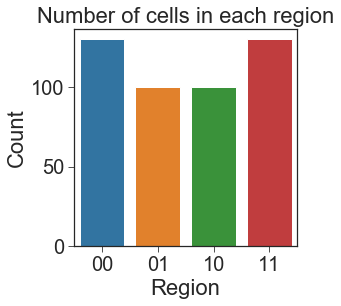

In [26]:
# Number of observations in each region
sns.countplot(x="region", data=df);
plt.xlabel("Region");
plt.ylabel("Count");
plt.title("Number of cells in each region");

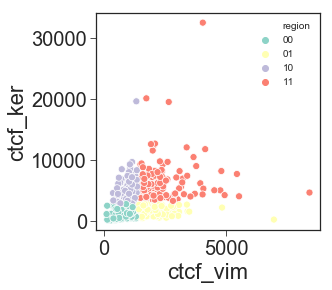

In [27]:
sns.scatterplot(x=df.ctcf_vim, y=df.ctcf_ker, 
                hue=df.region, s=50,
                palette=sns.color_palette("Set3", 4));

In [ ]:
tmp = df.groupby(['stiffness', 'region']).size().unstack()

tmp['total'] = df.groupby('stiffness').size()

tmp['00'] = tmp['00'] / tmp.total * 100
tmp['01'] = tmp['01'] / tmp.total * 100
tmp['10'] = tmp['10'] / tmp.total * 100
tmp['11'] = tmp['11'] / tmp.total * 100

tmp.iloc[:, 0 : 4].plot(kind='bar', width=0.7, stacked=True, palette=sns.color_palette("Set3", 4));


plt.xticks(rotation='horizontal')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18, 
           labels=('Low cytokeratins, low vimentin', 
                   'Low cytokeratins, high vimentin', 
                   'High cytokeratins, low vimentin', 
                   'High cytokeratins, high vimentin'));
plt.xlabel("Stiffness, kPa");
plt.ylabel("Proportion");
# plt.title("Proportion of cells of each type across stiffness values");

In [ ]:
cols = geom_cols

X = df[cols]
y = df.region

rf_clf = train_test_rf_clf(X, y)
important_features(X, rf_clf)

In [ ]:
plt.rcParams['figure.figsize'] = (4, 4)

sns.boxplot(x=df.region, y=df.meanradius_cyto, showfliers=False);

# Predict CV ratio using morphological features

In [ ]:
p_corr = df[geom_cols].corrwith(df.cvratio)
p_corr.abs().sort_values(ascending=False).head(10)

In [ ]:
cols = geom_cols

X = df[cols]
y = df.cvratio

rf_reg = train_test_rf_reg(X, y)

In [ ]:
df['cvratio2'] = np.where(df.cvratio < df.cvratio.quantile(0.75), 0, 1)

In [ ]:
cols = geom_cols

X = df[cols]
y = df.cvratio2

rf_clf = train_test_rf_clf(X, y)

In [ ]:
df.cvratio.median()